# Load libraries & data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [3]:
# Rebuild text
from sklearn_bridge import recreate_text_representation
# take text + labels from train ds
from sklearn_bridge import candidate_dict_to_df

In [4]:
from MLutils import report_to_df, train_evaluate, diversity_heatmap

In [5]:
import sklearn, pickle, time, seaborn
import pandas as pd
from itertools import product

In [6]:
with open('candidates_TrainValTestOutgoing.pickle', 'rb') as f:
    candidate_dict = pickle.load(f)

for splt in candidate_dict.keys():
    print "Split = %i : imported %i candidates" %(splt, len(candidate_dict[splt].keys()))

Split = 0 : imported 12968 candidates
Split = 1 : imported 3237 candidates
Split = 2 : imported 8278 candidates
Split = 3 : imported 79460 candidates


# Set pipeline options

In [7]:
#TODO: Implement:
# shortest dependency path
# feature combination

In [27]:
shortest_dep_paths = [False]
trimmings = [(False,0), 
             #(True,0), (True, 5)
            ]
use_lemmas_ = [#True, 
               False]
random_undersample_ = [True]
text_vectorizer_ = [CountVectorizer(binary=True, min_df=1 , stop_words='english', ngram_range=(2,2)),
#                    CountVectorizer(binary=True, min_df=5 , stop_words='english'),
                    TfidfVectorizer(binary=False, min_df=1 , stop_words='english', ngram_range=(2,2) ),
#                     TfidfVectorizer(binary=True, min_df=5 , stop_words='english'),
                   ]
lsa_dims = [None]


In [28]:
# select models to train
models = {
    'LogisticRegression': LogisticRegression(),
#     'SVC_linear': SVC(kernel = 'linear'),
# #     'SVC_rbf': SVC(kernel = 'rbf'),
# #     'SVC_rbf_C=100': SVC(kernel = 'rbf', C=100),
#     'SVC_rbf_C=500': SVC(kernel = 'rbf', C=500),
# #     'SVC_rbf_C=1000': SVC(kernel = 'rbf', C=1000),
# #     'kNN_5': KNeighborsClassifier(),
#     'RandomForestClassifier': RandomForestClassifier(n_estimators=100, max_depth=5),
}

In [29]:
#see ngram meaning 

In [34]:
text_vectorizer.vocabulary_.keys()[:3]

[u'group increased', u'level remained', u'apparent low']

In [31]:
# list(map(lambda x: len(x),text_vectorizer.vocabulary_.keys()))

In [32]:
combs = product(trimmings,use_lemmas_, random_undersample_, text_vectorizer_, lsa_dims, shortest_dep_paths)
combs = list(combs)
print len(combs)*len(models)


2


# Perform training

In [33]:
debug=False
start_time = time.time()
for comb in combs: 
    
    #pass pipeline selections
    (trim_text,trim_window) = comb[0]
    use_lemmas = comb[1]
    random_undersample = comb[2]
    text_vectorizer = comb[3]
    lsa_dims = comb[4]
    shortest_dep_path = comb[5]
    
    # determine name
    pkl_name = 'results_dict,'
    if shortest_dep_path:
        pkl_name += 'ShortDepPath,'
    elif trim_text:
        pkl_name += 'trim='+str(trim_window)+','
    if use_lemmas:
        pkl_name += 'lemmas'+','
    if random_undersample:
        pkl_name += ',RuS'+','
    #CV, TFIDF
    if isinstance(text_vectorizer, TfidfVectorizer):
        pkl_name += ',TfIdf_'+','
    elif isinstance(text_vectorizer, CountVectorizer):
        pkl_name += ',CV_'+','      
    if text_vectorizer.binary:
        pkl_name += 'bin_'+','
    if text_vectorizer.min_df:
        pkl_name += 'minFreq='+str(text_vectorizer.min_df)+','
    if text_vectorizer.stop_words:
        pkl_name += '_stopw='+str(text_vectorizer.stop_words)+','
    if text_vectorizer.ngram_range:
        pkl_name += '_ngrams='+str(text_vectorizer.ngram_range)+','
    if lsa_dims:
        pkl_name += ',LSA'+str(lsa_dims)+','
    pkl_name = pkl_name.replace(',,',',')
    
    # Debug pkl name
    if debug:
        print pkl_name
        continue
    
    
    print 'Saving as: \n'+pkl_name.strip(',')+'.pkl'
    print time.time() - start_time
    print ''
    
    if shortest_dep_path:
        #reload from pickle df_train,val,test etc
        with open('SDP_df_TrainValTestUnlab.pickle' , 'rb') as f:
            (df_train1, df_val1, df_test1, df_unlab1) = pickle.load(f)
            
    else:
        # create train/test set
        df_train = candidate_dict_to_df(candidate_dict[0],trim_text=trim_text, window=trim_window, lemmas = use_lemmas ,shortest_dep_path = shortest_dep_path)
        df_val = candidate_dict_to_df(candidate_dict[1],trim_text=trim_text, window=trim_window, lemmas =  use_lemmas,shortest_dep_path = shortest_dep_path )
        df_test = candidate_dict_to_df(candidate_dict[2],trim_text=trim_text, window=trim_window, lemmas = use_lemmas ,shortest_dep_path = shortest_dep_path)
        df_unlab = candidate_dict_to_df(candidate_dict[3],trim_text=trim_text, window=trim_window, lemmas = use_lemmas ,shortest_dep_path = shortest_dep_path)
    
    
    # text 2 matrix (CV/TF-idf)
    X_train = text_vectorizer.fit_transform(df_train.text)
    y_train = df_train.label

    X_val = text_vectorizer.transform(df_val.text)
    y_val = df_val.label
    
    X_test = text_vectorizer.transform(df_test.text)
    y_test = df_test.label
    
    X_unlab = text_vectorizer.transform(df_unlab.text)
    y_unlab = df_unlab.label
    
    # LSA
    if lsa_dims: #TODO save in diff. matrix to append later?
        svd = TruncatedSVD(n_components=lsa_dims)
        X_train = svd.fit_transform(X_train)
        X_val = svd.transform(X_val)
        X_test = svd.transform(X_test)
        X_unlab = svd.transform(X_unlab)
    
    # undersampling
    if random_undersample:
        import imblearn
        from collections import Counter
        from imblearn.under_sampling import RandomUnderSampler
#         print('Original dataset shape {}'.format(Counter(y_train)))
        rus = RandomUnderSampler(random_state=42)
        X_train, y_train = rus.fit_sample(X_train, y_train)
#         print('Resampled dataset shape {}'.format(Counter(y_train)))

    # train/predict, construct results_dict
    results_dict = dict()
    for model_name,model in models.iteritems():
#         print 'Training',model_name
#         start_time = time.time()

        try:
            model.probability = True
        except:
            pass
        
        #train & predict
        model.fit(X_train,y_train)
        # val predictions
        y_val_pred_bin = model.predict(X_val)
        y_val_pred_prob = pd.Series(map(lambda x: x[0],model.predict_proba(X_val)),index=y_val.index).to_dict()
        # test predictions
        y_test_pred_bin = model.predict(X_test)
        y_test_pred_prob = pd.Series(map(lambda x: x[0],model.predict_proba(X_test)),index=y_test.index).to_dict()
        # unlab set predictions
        y_unlab_pred_bin = model.predict(X_unlab)
        y_unlab_pred_prob = pd.Series(map(lambda x: x[0],model.predict_proba(X_unlab)),index=y_unlab.index).to_dict()
        
        #TODO: get probability labels in consistent way. which class is true if proba > 0.5???
        
        # TODO: do smth for later, when true lbls not in place.
        
        # calculate some metrics
        class_report = report_to_df(classification_report(y_val, y_val_pred_bin))
#         conf_matrix = confusion_matrix(y_val, y_val_pred_bin)

        results_dict[model_name] = {"label_val_binary" : y_val_pred_bin,
                                    "label_val_prob_dict" : y_val_pred_prob,
                                    "label_test_binary" : y_test_pred_bin,
                                    "label_test_prob_dict" : y_test_pred_prob,
                                    "label_unlab_binary" : y_unlab_pred_bin,
                                    "label_unlab_prob_dict" : y_unlab_pred_prob,
                                    #only possible when true labels in place:
#                                     "confusion_matrix" : conf_matrix,
                                    "classification_report": class_report,
    #                                 "precision": class_report.loc['avg/total','precision'],
    #                                 "recall": class_report.loc['avg/total','recall'],
                                    "f1+": class_report.loc['1','f1-score'],

                                   }
#         print "%s done. (%.2f sec)"%(model_name,time.time()-start_time)
        
        
    #save predictions in dict
    with open('ml_predictions/'+pkl_name+'.pkl', 'wb') as f:
        pickle.dump(results_dict,f)
        
#     diversity_heatmap(results_dict, title = pkl_name)

Saving as: 
results_dict,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(2, 2).pkl
0.00168299674988

Saving as: 
results_dict,RuS,TfIdf_,minFreq=1,_stopw=english,_ngrams=(2, 2).pkl
280.70291996



### For saving shortest dependency path matrix (takes ~30 mins to compute)

In [16]:

# # candidate_dict_to_df(candidate_dict[2],trim_text=trim_text, window=trim_window, lemmas = use_lemmas ,shortest_dep_path = shortest_dep_path)
# with open('SDP_df_TrainValTestUnlab.pickle' , 'wb') as f:
#     pickle.dump((df_train, df_val, df_test, df_unlab), f)

In [ ]:
from MLutils import cohen_kappa_score

In [34]:
results_dict['LogisticRegression'].keys()

['label_unlab_binary',
 'label_val_prob_dict',
 'label_test_binary',
 'f1+',
 'label_test_prob_dict',
 'classification_report',
 'label_val_binary',
 'label_unlab_prob_dict']

In [37]:
results_dict['LogisticRegression']['label_val_prob_dict']

{24576: 0.6634639645339768,
 24577: 0.6790412844071936,
 24578: 0.6773958236166169,
 24579: 0.5292209256481823,
 24580: 0.8191378129584771,
 24581: 0.7386449721375684,
 24589: 0.6251083973149021,
 24590: 0.7476152323477159,
 24591: 0.7476152323477159,
 24592: 0.43252824007456614,
 24593: 0.44474776919508097,
 24594: 0.429968572879854,
 24595: 0.6267683509447799,
 24596: 0.3484618437321385,
 24597: 0.5720863019885143,
 24598: 0.5768568977632238,
 24599: 0.592621718741658,
 24600: 0.526841920144616,
 24601: 0.5213880480009219,
 24602: 0.54697014147388,
 24603: 0.4809306406510889,
 24604: 0.5593735456760709,
 24605: 0.6730280786781039,
 24606: 0.6021584469478232,
 24607: 0.6358479699545919,
 24608: 0.6484395837448242,
 24609: 0.82463618525878,
 24610: 0.8133723708920111,
 24619: 0.6631173970757568,
 24620: 0.6989021855675284,
 24621: 0.7024651229790689,
 24622: 0.7245811036226089,
 24623: 0.6872004645906902,
 24624: 0.7145315537452789,
 24625: 0.6170576328174378,
 24626: 0.673058228847349

In [18]:
cohen_kappa_score(results_dict['SVC_rbf_C=500']['label_unlab_binary'],
                  results_dict['LogisticRegression']['label_unlab_binary'],
                 )

0.8728565139460202

In [16]:
results_dict['LogisticRegression'][ 'classification_report']

,precision,recall,f1-score,support
Classes,,,,
-1,0.89,0.77,0.83,2532
1,0.45,0.67,0.54,705
avg/total,0.80,0.75,0.76,3237


# Explore diversity between classifiers

In [27]:
# from sklearn.metrics import cohen_kappa_score
# from matplotlib import pyplot as plt

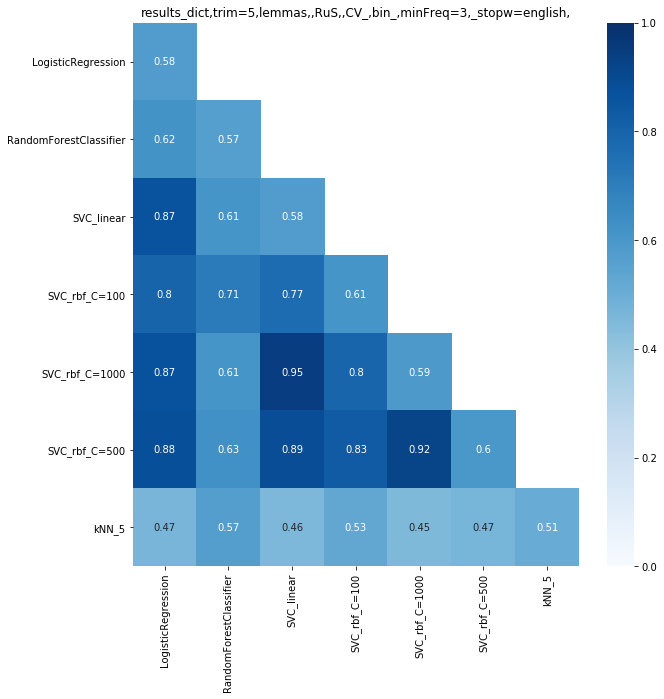

In [29]:
diversity_heatmap(results_dict, title = pkl_name)

In [32]:
# #whats going on with svc poly etc

# cohen_kappa_score(results_dict['SVC_poly3_C=100']['label_binary'],
#                  results_dict['SVC_poly3_C=1000']['label_binary'])
# #bcause results are same -> nan ?? 


In [37]:
# results_a = SVC(kernel = 'rbf', C=1000).fit(X_train_dev,y_train_dev).predict(X_test)
# results_b = SVC(kernel = 'linear').fit(X_train_dev,y_train_dev).predict(X_test)


In [28]:
# ## Check cohens kappa for individual models
# def cohens_kappa_quick_check(model1,model2):
#     """
#     Returns Cohens kappa interannotator agreement between on two models
#     (after training on dev+train and predicting in X_test)
#     """
#     results_a = model1.fit(X_train_dev,y_train_dev).predict(X_test)
#     results_b = model2.fit(X_train_dev,y_train_dev).predict(X_test)
#     return cohen_kappa_score(results_a, results_b)


# cohens_kappa(SVC(kernel = 'rbf', C=1000),
#              SVC(kernel = 'linear'))

# cohens_kappa(SVC(kernel = 'rbf', C=1000),
#              SVC(kernel = 'rbf', C=500),
#             )